# Evaluate models

In [1]:
import keras
from keras.models import load_model
import shap
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [56]:
#Load 15 axis data
print('Beginning loading')
X_train = np.load('processed_datasets/age_X_15_second_test.npy')
y_train = np.load('processed_datasets/age_y_15_second_test.npy')
ids_train = np.load('processed_datasets/age_ids_15_second_test.npy')

print('Finished loading, beginning X_train axis adjustment')

#Change X_train to weird format
X_train = np.expand_dims(X_train, 1)
X_train = np.swapaxes(X_train, -1, -2)

#Randomize
if False:
    print('Data will be randomized.')
    idxs = np.arange(X_train.shape[0])
    np.random.shuffle(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]
    ids_train = ids_train[idxs]
else:
    print('Data is NOT randomized.')

print('Extracting val set')
val_ids = np.load('processed_datasets/gender_ids_15.npy')
val_ids = val_ids[int(0.8*val_ids.shape[0]) : ]
#val_ids = set(val_ids)

val_idxs = np.isin(ids_train, val_ids)
X_val = X_train[val_idxs]
y_val = y_train[val_idxs]
ids_val = ids_train[val_idxs]

X_train.shape, y_train.shape, ids_train.shape, X_val.shape, y_val.shape,  ids_val.shape

Beginning loading
Finished loading, beginning X_train axis adjustment
Beginning y_train encoding
Data is NOT randomized.
Extracting val set


((1635352, 1, 15, 100),
 (1635352,),
 (1635352,),
 (330494, 1, 15, 100),
 (330494,),
 (330494,))

In [6]:
#Load in the model
model = load_model('models/gender_model_15_unrand.h5', custom_objects=model_metrics)
model.summary()

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
acc_input (InputLayer)       (None, 1, 15, 100)        0         
_________________________________________________________________
swapaxes_acc (Permute)       (None, 1, 100, 15)        0         
_________________________________________________________________
block1_conv1_acc (Conv2D)    (None, 1, 100, 32)        1472      
_________________________________________________________________
block1_bn1_acc (BatchNormali (None, 1, 100, 32)        128       
_________________________________________________________________
block1_act1_acc (ELU)        (None, 1, 100, 32)        0         
_________________________________________________________________
block1_conv2_acc (Conv2D)    (None, 1, 100, 32)        3104      
_________________________________________________________________
block1_bn2_acc (BatchNormali

In [58]:
#Make predictions
y_pred = model.predict(X_train, batch_size = 512).round().squeeze()
y_pred_val = y_pred[val_idxs]

In [62]:
#Get overall accuracy
print((y_pred == y_train).mean())
print((y_pred_val == y_val).mean())

0.831756098992755
0.7976332399377901


In [60]:
# Get male accuracy
male_idxs = y_train == 1
print((y_pred[male_idxs] == 1).mean())

male_idxs = y_val == 1
print((y_pred_val[male_idxs] == 1).mean())

0.874748619264411
0.854611310792328


In [61]:
# Get female accuracy
female_idxs = y_train == 0
print((y_pred[female_idxs] == 0).mean())

female_idxs = y_val == 0
print((y_pred_val[female_idxs] == 0).mean())

0.6780336308441286
0.6161910308677927


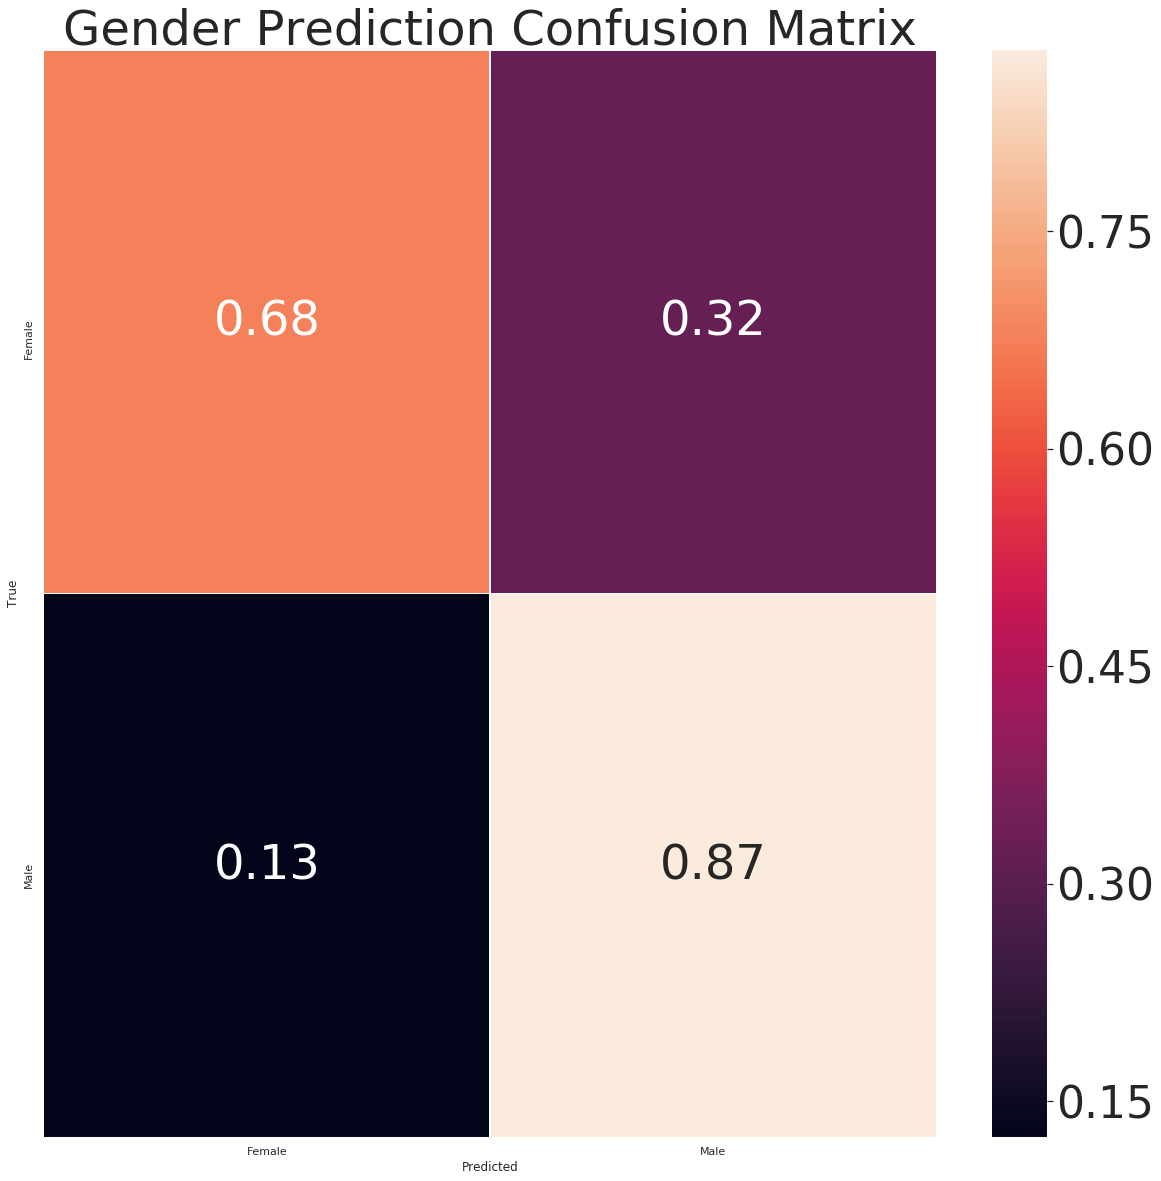

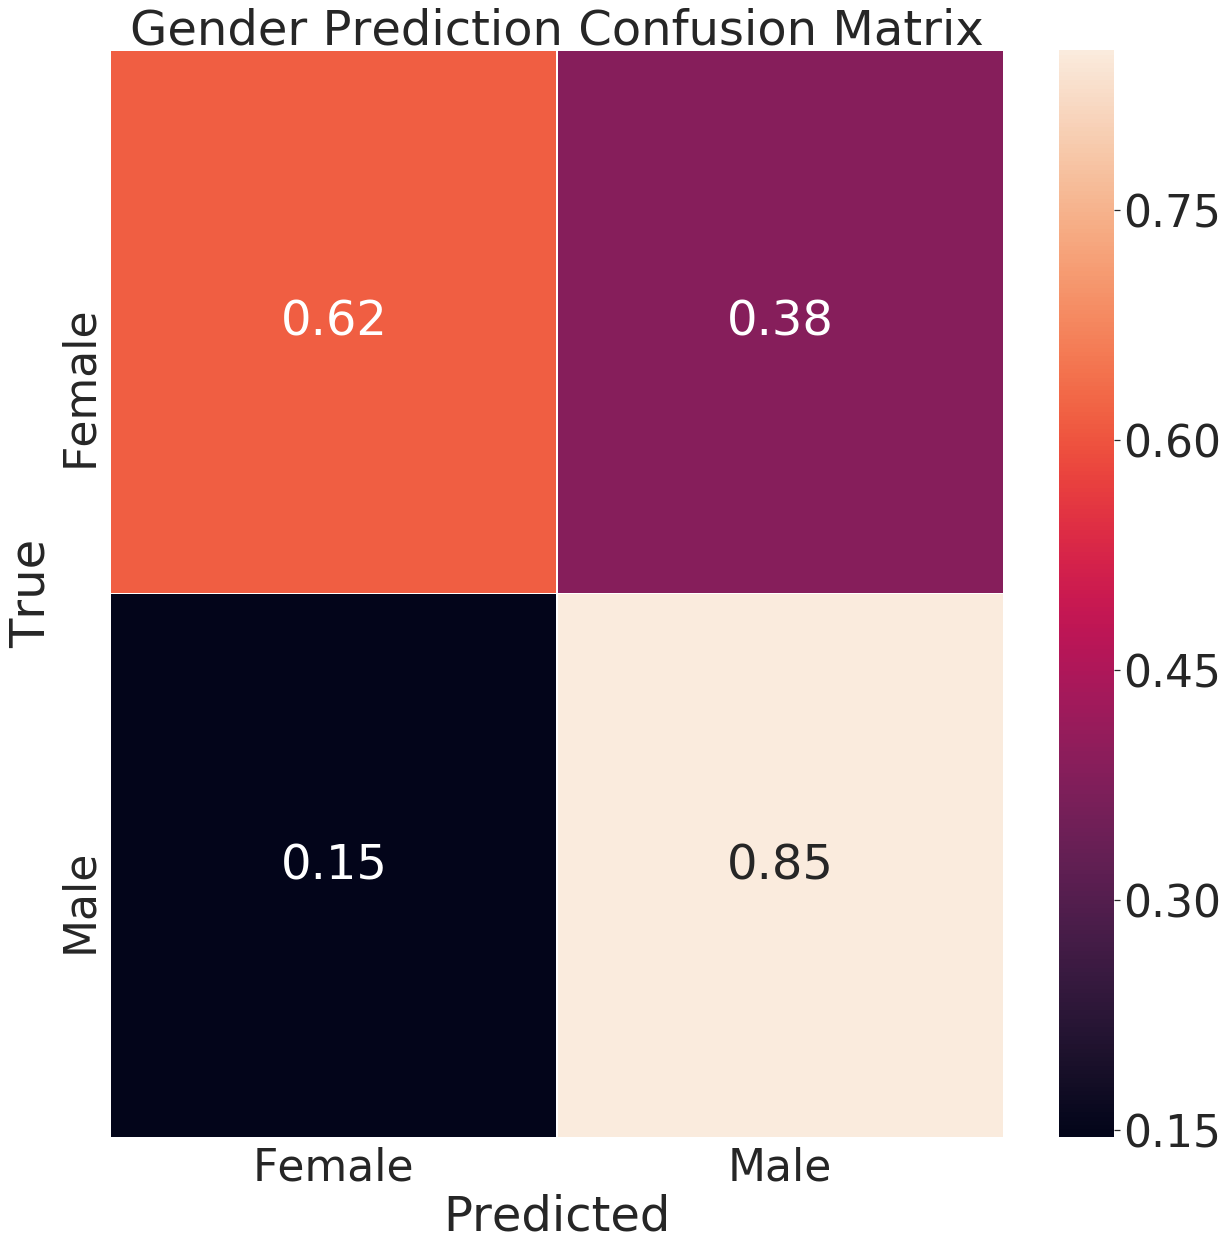

In [63]:
#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((y_train,y_pred)),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((y_val,y_pred_val)),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')
sns.set(font_scale = 1)

# User Level

In [40]:
# Get user level accuracy
unique_ids = np.unique(ids_train)
print(f'There are {len(unique_ids)} unique ids in our val set.')

user_preds = []
user_trues = []
user_correctness = []

overall_acc = []
male_acc = []
female_acc = []
for usr_id in unique_ids:
    
    usr_idxs = np.nonzero(ids_train == usr_id)[0]
    
    #print(f'User {usr_id} has {len(usr_idxs)} in the val set.')

    prop_one = np.sum(y_pred[usr_idxs])/len(usr_idxs)
    pred = prop_one > 0.5
    true = y_train[usr_idxs[0]]
    #print(f'This user has label {true} with vote {temp} leading to a aggregate prediction of {pred}.')

    user_preds.append(pred)
    user_trues.append(true)
    
    overall_acc.append(true == pred)
    if true == 1:
        male_acc.append(true == pred)
        user_correctness.append(prop_one)
    else:
        female_acc.append(true == pred)
        user_correctness.append(1 - prop_one)

There are 2304 unique ids in our val set.


In [41]:
np.mean(overall_acc)

0.9001736111111112

In [42]:
np.mean(male_acc)

0.9438888888888889

In [43]:
np.mean(female_acc)

0.7440476190476191

(array([  35.,   40.,   41.,   54.,   60.,  102.,  117.,  165.,  357.,
        1333.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

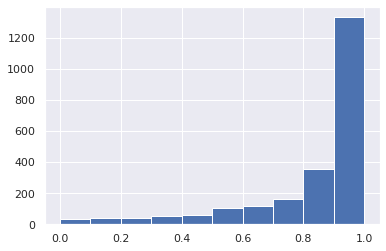

In [44]:
# Get histogram of individual accuracy
plt.hist(user_correctness)

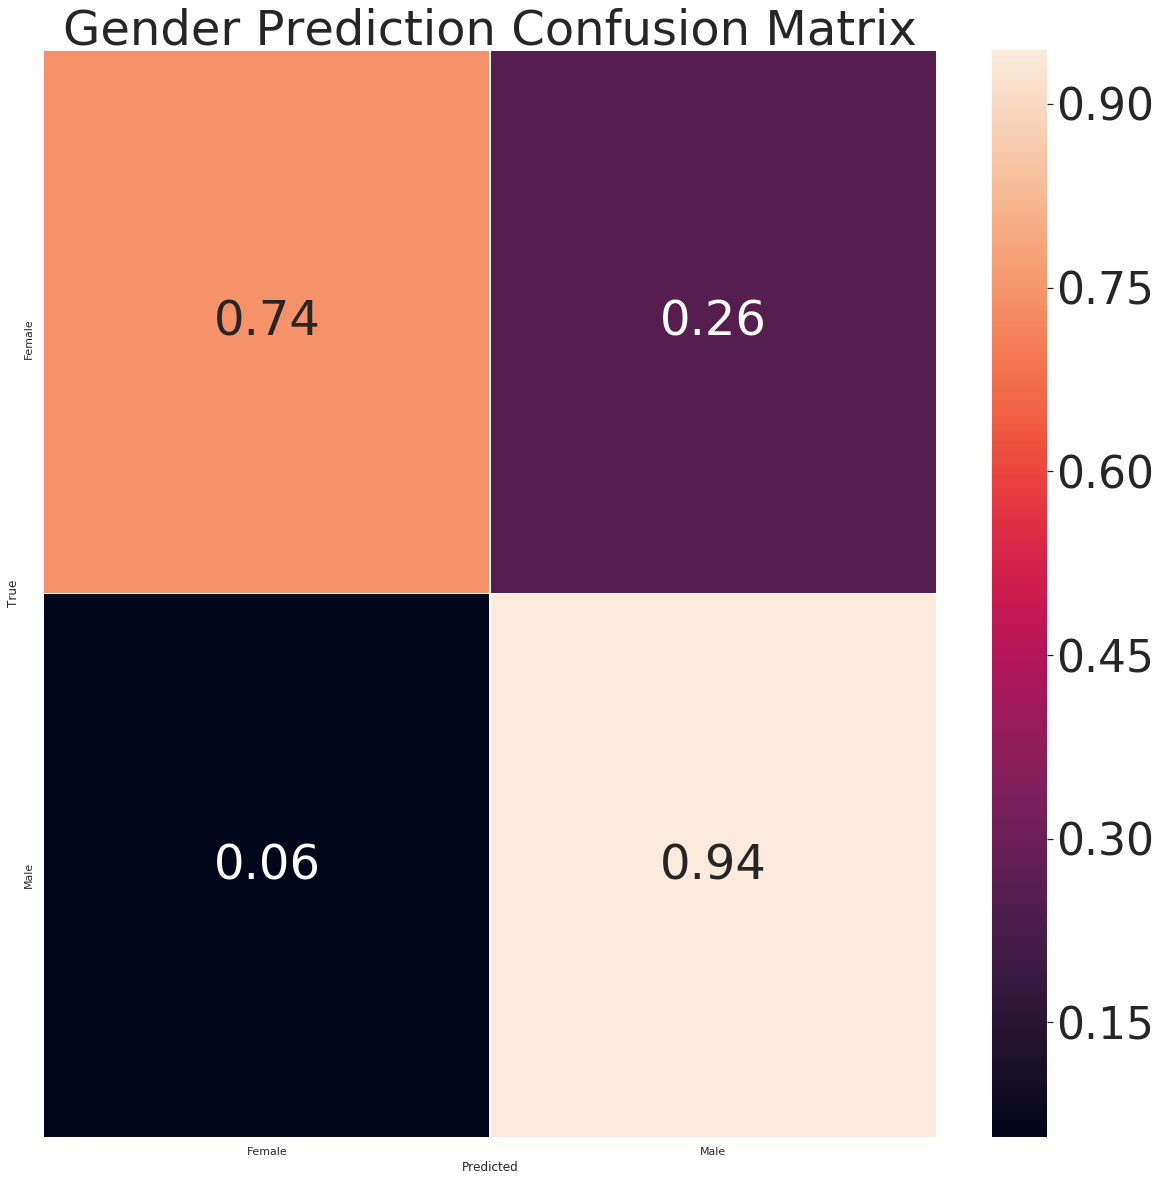

In [45]:
#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((user_trues,user_preds)),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['Female', 'Male'],
            yticklabels = ['Female', 'Male'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')
sns.set(font_scale = 1)